In [30]:
! pip install spotipy pandas

In [10]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd

In [11]:
# spotify credentials
client_id = "340ebe283d9f462489c995e108401871"
client_secret = "a84f4bc0ce67494c969e7a9b818ce574"
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

In [12]:
# function to get the audio features of a song
def get_tracks_from_playlist(playlist_id):
    tracks = []
    results = sp.playlist_tracks(playlist_id)
    
    while results:
        for item in results["items"]:
            track = item["track"]
            if track:
                tracks.append({
                    "track_id": track["id"],
                    "album_id": track["album"]["id"],
                    "artist_id": track["artists"][0]["id"],  # Primary artist
                    "release_date": track["album"]["release_date"],
                    "popularity": track["popularity"]
                })
        results = sp.next(results)
    
    return pd.DataFrame(tracks)

In [13]:
# get artists genres
def get_artist_genres(artist_ids):
    artist_data = []
    # Fetch artist info in batches of 50 (Spotify API limit)
    for i in range(0, len(artist_ids), 50):
        batch = artist_ids[i:i+50]
        artists = sp.artists(batch)["artists"]
        for artist in artists:
            genres = artist.get("genres", [])
            genre_list = genres if genres else ["Unknown"]
            for genre in genre_list:
                artist_data.append({
                    "artist_id": artist["id"],
                    "genres": genre
                })
    return pd.DataFrame(artist_data)

In [14]:
# get album details
def get_album_details(album_ids):
    albums = []
    # Fetch album info in batches of 20 (Spotify API limit)
    for i in range(0, len(album_ids), 20):
        batch = album_ids[i:i+20]
        album_results = sp.albums(batch)["albums"]
        for album in album_results:
            albums.append({
                "album_id": album["id"],
                "release_date": album["release_date"]
            })
    return pd.DataFrame(albums)

In [15]:
# Get tracks from a playlist (replace with a real playlist ID)
playlist_id = "7c2c13pKxvFDSV4WSyydyg"  # Example: Spotify's Top Hits 2025 playlist
tracks_df = get_tracks_from_playlist(playlist_id)

In [16]:
def calculate_genre_popularity(playlist_id):
    # 1. Get tracks from the playlist
    tracks_df = get_tracks_from_playlist(playlist_id)

In [17]:
 # 2. Get unique artist and album IDs
unique_artist_ids = tracks_df["artist_id"].unique()
unique_album_ids = tracks_df["album_id"].unique()

In [18]:
   # 3. Get artist genres and album release dates
artists_df = get_artist_genres(unique_artist_ids)
albums_df = get_album_details(unique_album_ids)

In [19]:
 # 4. Merge data to combine all information
merged_df = (
    tracks_df.merge(albums_df, on="album_id", how="left")  # Merge album release_date
    .merge(artists_df, on="artist_id", how="left")  # Merge artist genres
)

In [20]:
def calculate_avg_popularity(merged_df):
    # 5. Group by genres and release_date_y to calculate avg_popularity
    result_df = (
        merged_df.groupby(["genres", "release_date_y"])
        .agg(avg_popularity=("popularity", "mean"))
        .reset_index()
        .sort_values(by="release_date_y")
    )
    
    return result_df

In [21]:
# Get genre popularity over time
genre_popularity_df = calculate_genre_popularity(playlist_id)

# Display result
print(merged_df)

                    track_id                album_id               artist_id  \
0     33FPsMEl3UwpytDuyf9VYq  2KaqhTuykw9yrstJJMgiBe  73sSFVlM6pkweLXE8qw1OS   
1     33FPsMEl3UwpytDuyf9VYq  2KaqhTuykw9yrstJJMgiBe  73sSFVlM6pkweLXE8qw1OS   
2     5zyrEv4F3FaLECI8TOKpFM  490sLjsTmSo7MnA8noKMOH  4llklDtTTyMYMY2LfFOkTI   
3     5zyrEv4F3FaLECI8TOKpFM  490sLjsTmSo7MnA8noKMOH  4llklDtTTyMYMY2LfFOkTI   
4     5zyrEv4F3FaLECI8TOKpFM  490sLjsTmSo7MnA8noKMOH  4llklDtTTyMYMY2LfFOkTI   
...                      ...                     ...                     ...   
1598  0Z7nGFVCLfixWctgePsRk9  6cBlaud5JVmPjkjxnwIMLx  6vWDO969PvNqNYHIOW5v0m   
1599  3w0w2T288dec0mgeZZqoNN  30zwjSQEodaUXCn11nmiVF  4xPQFgDA5M2xa0ZGo5iIsv   
1600  51ZQ1vr10ffzbwIjDCwqm4  5EYKrEDnKhhcNxGedaRQeK  66CXWjxzNUsdJxJ2JdwvnR   
1601  6usohdchdzW9oML7VC4Uhk  5QMiub2LonMqxB7dhtbPlX  33qOK5uJ8AR2xuQQAhHump   
1602  2tudvzsrR56uom6smgOcSf  4iqbFIdGOTzXeDtt9owjQn  1RyvyyTE3xzB2ZywiAwp0i   

     release_date_x  popularity release

In [22]:
# Save the resulting DataFrame to a CSV file
merged_df.to_csv("genre_popularity_over_time.csv", index=False)

print("CSV file saved as 'genre_popularity_over_time.csv'!")

CSV file saved as 'genre_popularity_over_time.csv'!


In [23]:
# Count the number of occurrences of each genre
genre_count_df = merged_df.groupby("genres").size().reset_index(name="count")

# Display the genre count DataFrame
print(genre_count_df)

                  genres  count
0                Unknown    487
1              acid rock     10
2       acoustic country      1
3        adult standards     32
4              afro soul      1
..                   ...    ...
121  traditional country      2
122                 trap      1
123    variété française      3
124           vocal jazz      7
125   west coast hip hop      5

[126 rows x 2 columns]


In [24]:
# Save the genre count to a CSV file
genre_count_df.to_csv("genre_count.csv", index=False)
print("CSV file saved as 'genre_count.csv'!")

CSV file saved as 'genre_count.csv'!


Motown is the most popular genre from 1958 to 2024

In [25]:
artists_df = merged_df.groupby("artist_id").size().reset_index(name="count")
print(artists_df)


                  artist_id  count
0    01gp5ElAZTH3BNkFII1qPM      1
1    01hRNr3yF5bYnPq4wZ88iI      2
2    04LIHk1SobiQwt2tlupoAV      2
3    04gDigrS5kc9YWfZHwBETP      4
4    05RZIdfz59ZW2FvFuwnmNK      1
..                      ...    ...
648  7xAcVHPiirnUqfdqo0USb1      1
649  7xGGqA85UIWX1GoTVM4itC      4
650  7xTcuBOIAAIGDOSvwYFPzk      1
651  7xkAwz0bQTGDSbkofyQt3U      1
652  7y0ngZzIllkP8ZOqgTKQFc      1

[653 rows x 2 columns]


In [26]:
artists_df.to_csv("artists.csv", index=False)
print("CSV file saved as 'artists.csv'!")   









CSV file saved as 'artists.csv'!


In [27]:
popularity_df = merged_df.groupby("popularity").size().reset_index(name="count")
print(popularity_df)



    popularity  count
0            0    113
1            1     24
2            2     22
3            3     13
4            4      9
..         ...    ...
77          85      9
78          86     14
79          87      7
80          88      8
81          89      5

[82 rows x 2 columns]


In [28]:
popularity_df.to_csv("popularity.csv", index=False)
print("CSV file saved as 'popularity.csv'!")

CSV file saved as 'popularity.csv'!


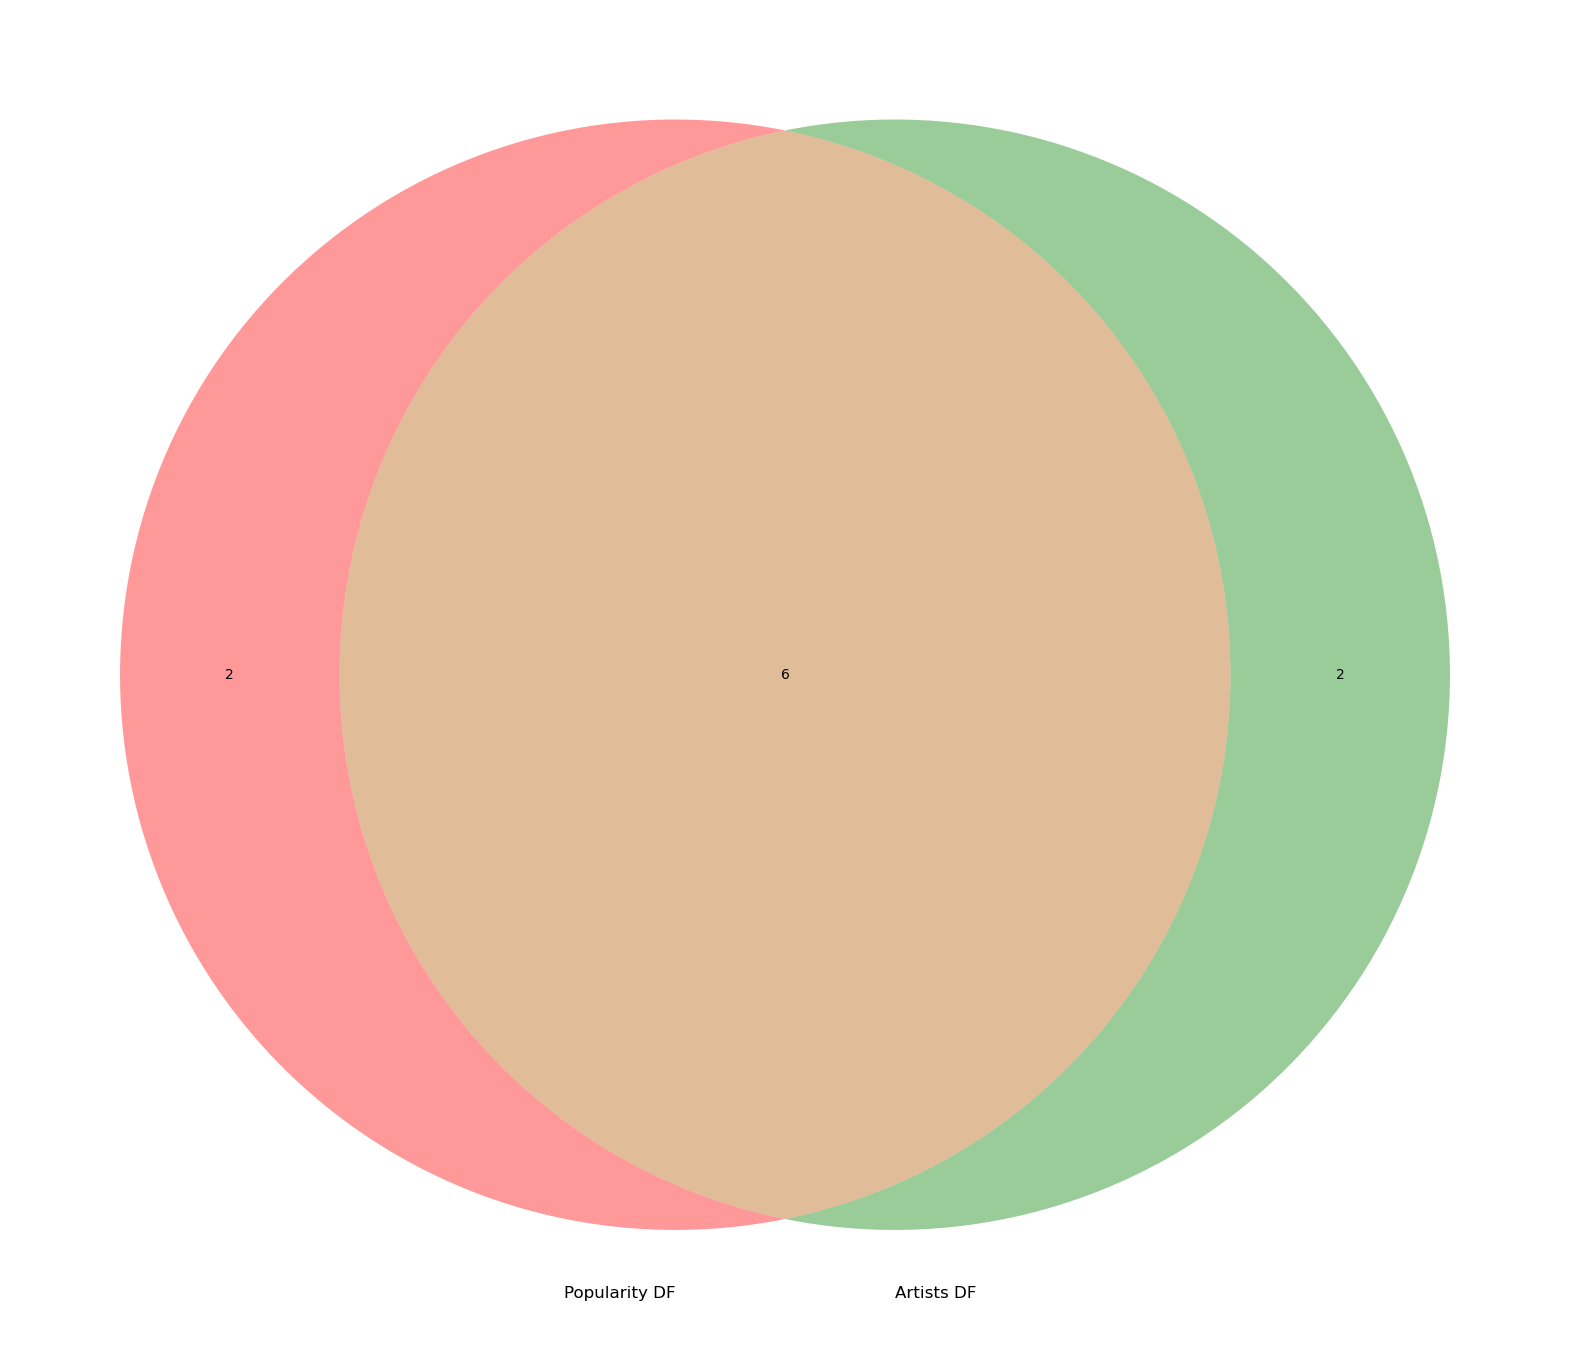

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Sample DataFrames 
popularity_df = pd.DataFrame({'artist_name': ['Drake', 'Beyoncé', 'Eminem', 'Adele', 'Taylor Swift', 'Ed Sheeran', 'Ariana Grande', 'Justin Bieber']})  
artists_df = pd.DataFrame({'artist_name': ['Eminem', 'Adele', 'Taylor Swift', 'Ed Sheeran', 'Ariana Grande', 'Justin Bieber', 'Kanye West', 'Rihanna']})

# Convert columns to sets
set_popularity = set(popularity_df['artist_name'])
set_artists = set(artists_df['artist_name'])

# Create Venn diagram
plt.figure(figsize=(20,20))
venn2([set_popularity, set_artists], ('Popularity DF', 'Artists DF'))

# Show the plot
plt.show()
